In [2457]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

In [2458]:
def Plot_curve(data_arr,Y_legends,
                X_label,Y_label,
                title,
                marker_list,linestyle_list,
                colors_list=['green','mediumblue','tomato','orange','deepskyblue','lightskyblue','black','red']*2,
                bbox_to_anchor=(),
                text="",
                dpi=400):
    #Plot parameters
    figsize = (8,6)
    fonttype = "Helvetica"
    fontsize = 9
    grid_linewidth = 0.8
    plot_linewidth = 1.5

    plt.figure(figsize=figsize)
    idx = 0
    for data_idx in range(len(data_arr)):
        X       = data_arr[data_idx][:,0]           #X is a 2D array
        Y_arr   = data_arr[data_idx][:,1:]          #Y_arr is a 2D array
        for Y_idx in range(np.shape(Y_arr)[1]):
            plt.plot(X,Y_arr[:,Y_idx],label=Y_legends[idx],
                        color=colors_list[idx], marker=marker_list[idx],
                        linestyle=linestyle_list[idx], linewidth=plot_linewidth)
            idx = idx + 1


    plt.rcParams["font.family"] = fonttype
    plt.rcParams.update({'font.size': fontsize})
    plt.yticks(fontproperties = fonttype, size = fontsize)
    plt.xticks(fontproperties = fonttype, size = fontsize)
    plt.ylabel(Y_label, fontdict={'family' : fonttype, 'size' : fontsize})
    plt.xlabel(X_label, fontdict={'family' : fonttype, 'size' : fontsize})
    plt.title(title)
    if len(bbox_to_anchor)>0:
        plt.legend(bbox_to_anchor=bbox_to_anchor, loc='lower left', borderaxespad=0)
    else:
        plt.legend(loc='best')
    if not text == "":
        plt.text(np.quantile(X,0.75),np.quantile(Y_arr,0.05),
                text, bbox=dict(boxstyle="round,pad=0.9", fc="white", alpha=0.9))
    plt.grid(linewidth=grid_linewidth, alpha=0.3)
    savename = "results/"+str(title)+".jpg"
    plt.savefig(savename,dpi=dpi)
    plt.tight_layout()
    plt.show()


In [2459]:
def str2complex(s):
        str = s.replace(" ","")\
                .replace("(","")\
                .replace(")","")\
                .replace("i","j")
        return complex(str)


Plot the propagation constant data calculated using CMT and Lumerical

In [2460]:
def Load_uncoupled_data(filename_uncoupled):
    beta_uncoupled_arr = []
    with open(filename_uncoupled,'r') as f:
        data_uncoupled = f.readlines()
        for line in data_uncoupled[1:]:
            beta_uncoupled_arr.append(np.float64(line.split(",")))
    beta_uncoupled_arr = np.array(beta_uncoupled_arr)
    return beta_uncoupled_arr

def Load_coupled_data_CMT(filename_coupled, wavl_idx = 10):
    beta_coupled_arr = []
    coeff_supermode_1_arr = []
    coeff_supermode_2_arr = []
    with open(filename_coupled,'r') as f:
        data_coupled = f.readlines()
        for line in data_coupled[1:]:
            line = line.split(",")
            line_float = np.float64(line[:3])
            if line_float[1]<0:
                beta_coupled = [line_float[0],line_float[2],line_float[1]]
            else:
                beta_coupled = line_float[:3]
            assert len(beta_coupled) == 3
            assert len(line) == 7
            coeff_supermode_1 = [str2complex(line[3]),str2complex(line[4])]
            coeff_supermode_2 = [str2complex(line[5]),str2complex(line[6])]
            beta_coupled_arr.append(beta_coupled)
            coeff_supermode_1_arr.append(coeff_supermode_1)
            coeff_supermode_2_arr.append(coeff_supermode_2)
    beta_coupled_arr = np.array(beta_coupled_arr, dtype = np.float64)
    coeff_supermode_1_arr = np.array(coeff_supermode_1_arr, dtype = np.complex64)
    coeff_supermode_2_arr = np.array(coeff_supermode_2_arr, dtype = np.complex64)

    # coefficient of supermode at 1550nm
    print("wavelength = {:.2f}".format(beta_coupled_arr[wavl_idx,0]) + " um "\
        + "\nSupermode 1 coefficient : "  \
        + 'A = ({0.real:.6f} + {0.imag:.6f}i)'.format(coeff_supermode_1_arr[wavl_idx,0]) + ', '\
        + 'B = ({0.real:.6f} + {0.imag:.6f}i)'.format(coeff_supermode_1_arr[wavl_idx,1])\
        + "\nSupermode 2 coefficient : "  \
        + 'A = ({0.real:.6f} + {0.imag:.6f}i)'.format(coeff_supermode_2_arr[wavl_idx,0]) + ', '\
        + 'B = ({0.real:.6f} + {0.imag:.6f}i)'.format(coeff_supermode_2_arr[wavl_idx,1]))

    return beta_coupled_arr

def Load_coupled_data_Lumerical(filename_lumerical):
    beta_coupled_lumerical_arr_ori = []
    with open(filename_lumerical,'r') as f:
        data_lumerical = f.readlines()
        beta_ang_mode1 = 0
        for line in data_lumerical[2:]:
            wavelength  = float(line.split(',')[0])/1000 #unit:um
            modeidx     = int(line.split(',')[1])
            neff        = str2complex(line.split(',')[2])
            ng          = str2complex(line.split(',')[3])
            loss        = float(line.split(',')[4])
            polarization= float(line.split(',')[5])
            beta_ang    = float(line.split(',')[6])

            if modeidx == 1:
                # Mode 1
                beta_ang_mode1 = beta_ang
            else:
                # Mode 2
                beta_ang_mode2 = beta_ang
                beta_coupled_lumerical_arr_ori.append([wavelength,beta_ang_mode1,beta_ang_mode2])

    beta_coupled_lumerical_arr_ori = np.array(beta_coupled_lumerical_arr_ori)
    # beta_ave = beta_uncoupled_arr[:,3]
    beta_ave = (beta_coupled_lumerical_arr_ori[:,1] + beta_coupled_lumerical_arr_ori[:,2])/2
    beta_coupled_lumerical_arr = np.copy(beta_coupled_lumerical_arr_ori)
    beta_coupled_lumerical_arr[:,1] = beta_coupled_lumerical_arr_ori[:,1] - beta_ave
    beta_coupled_lumerical_arr[:,2] = beta_coupled_lumerical_arr_ori[:,2] - beta_ave
    return beta_coupled_lumerical_arr

In [2461]:
def Polynomial_fit(x,y_arr,order = 1, num_of_fit_pts  = 100):
    num_of_columns  = np.shape(y_arr)[1]
    coeffi_array    = np.zeros((order+1,num_of_columns))
    y_fit_arr       = np.zeros((num_of_fit_pts,num_of_columns))
    for idx in range(num_of_columns):

        y = y_arr[:,idx]
        coefficients = np.polyfit(x, y, order)
        coeffi_array[:,idx] = coefficients

        # a, b, c = coefficients
        # print(f"拟合的二次函数为: y = {a:.2f}x^2 + {b:.2f}x + {c:.2f}")

        x_fit = np.linspace(min(x), max(x), num_of_fit_pts)
        y_fit = np.polyval(coefficients, x_fit)
        y_fit_arr[:,idx] = y_fit

    return coeffi_array, y_fit_arr


In [2462]:
def Interpolation(x,y,x_intp,num_of_pts=100):
    cs = CubicSpline(x, y, bc_type='natural')  # bc_type 可选 'natural', 'clamped', 'periodic' 等
    y_intp = cs(x_intp)
    return y_intp

In [2463]:
# field_coefficients = [A,B]     E_supermode = A * E_1 + B * E_2
# E_1,E_2 are the eigenmodes of separate WGs. A,B are the coefficients
def Plot_field_profile(self,field,field_name,Plot_log = False,
                    save_name='./results/field_supermode_profile.jpg',dpi=600):
    fonttype = "Helvetica"
    fontsize = 4
    grid_linewidth = 1
    colormap = "jet"
    figsize =  (15,5)

    fig, ax = plt.subplots(1,3,figsize=figsize,dpi=dpi)
    plt.subplots_adjust(left=0.05, right=0.95, wspace =0.1, hspace =0.2)   #调整子图间距

    name_list = ['Abs','Re','Im']

    field_list = [np.abs(field),np.real(field),np.imag(field)]
    if Plot_log:
        field_list[0] = np.log(field_list[0])
    # Converting the unit of ticks to um
    yticks_prev = np.linspace(0,np.shape(field)[0],10)
    xticks_prev = np.linspace(0,np.shape(field)[1],10)
    xticks,yticks = self.Convert_ticks(xticks_prev,yticks_prev)

    for idx in range(3):
        # Plot the field profile
        im = ax[idx].imshow(field_list[idx], cmap=colormap)
        # Plot the boundaries of the WGs
        ax[idx].plot(WG1_x_arr,WG1_y_arr,color='black', linewidth=0.1)
        ax[idx].plot(WG2_x_arr,WG2_y_arr,color='black', linewidth=0.1)

        ax[idx].set_title(name_list[idx]+'('+field_name+')')
        cbar = fig.colorbar(im, ax=ax[idx], orientation='vertical',
                            label='', shrink=0.3, pad=0.02)
        ax[idx].set_xticks(xticks_prev)
        ax[idx].set_xticklabels(xticks)
        ax[idx].set_yticks(yticks_prev)
        ax[idx].set_yticklabels(yticks)
        ax[idx].set_xlabel(r'X($\mu m$)',fontsize=4)
        ax[idx].set_ylabel(r'Y($\mu m$)',fontsize=4)
        ax[idx].invert_yaxis()
        ax[idx].tick_params(axis='both',labelsize=5)

    plt.rcParams["font.family"] = fonttype
    plt.rcParams.update({'font.size': fontsize})
    plt.legend()

    plt.savefig(save_name,dpi=dpi)
    plt.close()
    # plt.show()
    return

1. Specify the name of the data files

Width of the inner waveguides is 8um
the gap between WGs : 4um or 5um

In [2464]:
filename_uncoupled_gap3um = "data/beta_uncoupled_gap_3.txt"
filename_coupled_gap3um = "data/beta_coupled_gap_3.txt"
# filename_lumerical_gap3um = "results/L_inner_8um_gapx_5&4um/gapx_4um/Lumerical_supermodes_results_gapx_4um.txt"

filename_uncoupled_gap4um = "results/L_inner_8um_gapx_5&4um/gapx_4um/beta_uncoupled_gap_4.txt"
filename_coupled_gap4um = "results/L_inner_8um_gapx_5&4um/gapx_4um/beta_coupled_gap_4.txt"
filename_lumerical_gap4um = "results/L_inner_8um_gapx_5&4um/gapx_4um/Lumerical_supermodes_results_gapx_4um.txt"

filename_uncoupled_gap5um = "results/L_inner_8um_gapx_5&4um/gapx_5um/beta_uncoupled_gap_5.txt"
filename_coupled_gap5um = "results/L_inner_8um_gapx_5&4um/gapx_5um/beta_coupled_gap_5.txt"
filename_lumerical_gap5um = "results/L_inner_8um_gapx_5&4um/gapx_5um/Lumerical_supermodes_results_gap_5.txt"

In [2465]:
filename_uncoupled_gap2_5um = "data/beta_uncoupled_gap_2_5.txt"
filename_coupled_gap2_5um = "data/beta_coupled_gap_2_5.txt"

Test data

In [2466]:
filename_uncoupled  = "data/beta_uncoupled_gap_5.txt"
filename_coupled    = "data/beta_coupled_gap_5.txt"
filename_lumerical  = "data/Lumerical_supermodes_results_gap_5.txt" #???
# filename_uncoupled_pre = "results/L_inner_8um_gapx_5&4um/gapx_4um/beta_uncoupled_L_inner_8um_gapx_4um_using_FDE@gap5um.txt"
# filename_coupled_pre = "results/L_inner_8um_gapx_5&4um/gapx_4um/beta_coupled_L_inner_8um_gapx_4um_using_FDE@gap5um.txt"
# filename_lumerical = "results/L_inner_8um_gapx_5&4um/gapx_4um/Lumerical_supermodes_results_gapx_4um_meshoverride.txt"

Width of the inner waveguides is 2.8um
the gap between WGs : 4um or 5um

In [2467]:
filename_uncoupled_L_inner_2_8  = "results/beta_uncoupled_L_inner_2_8um_gap_8um.txt"
filename_coupled_L_inner_2_8    = "results/beta_coupled_L_inner_2_8um_gap_8um.txt"
filename_lumerical_gap5um_L_inner_2_8 = "data/Lumerical_supermodes_results_L_inner_2_8um_gap_5um.txt"

Load propagation constant data from files listed above

In [2468]:
beta_uncoupled_arr_gap5um = Load_uncoupled_data(filename_uncoupled_gap5um)
beta_coupled_arr_gap5um = Load_coupled_data_CMT(filename_coupled_gap5um,wavl_idx=16)
beta_coupled_lumerical_arr_gap5um = Load_coupled_data_Lumerical(filename_lumerical_gap5um)
beta_coupled_lumerical_arr_gap5um[:5,:]

wavelength = 1.55 um 
Supermode 1 coefficient : A = (0.866886 + 0.000000i), B = (-0.503335 + -0.000000i)
Supermode 2 coefficient : A = (0.498506 + -0.000001i), B = (0.864092 + 0.000000i)


array([[ 1.54      ,  0.11515828, -0.11515828],
       [ 1.541     ,  0.10387946, -0.10387946],
       [ 1.542     ,  0.09265887, -0.09265887],
       [ 1.543     ,  0.08149966, -0.08149966],
       [ 1.544     ,  0.070407  , -0.070407  ]])

In [2469]:
beta_uncoupled_arr_gap4um = Load_uncoupled_data(filename_uncoupled_gap4um)
beta_coupled_arr_gap4um = Load_coupled_data_CMT(filename_coupled_gap4um,wavl_idx=16)
beta_coupled_lumerical_arr_gap4um = Load_coupled_data_Lumerical(filename_lumerical_gap4um)
beta_coupled_lumerical_arr_gap4um[:5,:]
np.shape(beta_uncoupled_arr_gap4um)

wavelength = 1.55 um 
Supermode 1 coefficient : A = (0.921469 + 0.000000i), B = (-0.393366 + -0.000000i)
Supermode 2 coefficient : A = (0.388453 + -0.000000i), B = (0.919382 + 0.000000i)


(31, 4)

In [2470]:
beta_uncoupled_arr_gap3um = Load_uncoupled_data(filename_uncoupled_gap3um)
beta_coupled_arr_gap3um = Load_coupled_data_CMT(filename_coupled_gap3um)

wavelength = 1.55 um 
Supermode 1 coefficient : A = (0.865401 + 0.000000i), B = (-0.608748 + -0.000000i)
Supermode 2 coefficient : A = (0.501081 + -0.000000i), B = (0.793364 + 0.000000i)


In [2471]:
beta_uncoupled_arr_gap2_5um = Load_uncoupled_data(filename_uncoupled_gap2_5um)
beta_coupled_arr_gap2_5um = Load_coupled_data_CMT(filename_coupled_gap2_5um)

wavelength = 1.54 um 
Supermode 1 coefficient : A = (0.829570 + 0.000000i), B = (0.676975 + 0.000000i)
Supermode 2 coefficient : A = (-0.558402 + 0.000000i), B = (0.736006 + 0.000000i)


In [2472]:
beta_uncoupled_arr = Load_uncoupled_data(filename_uncoupled)
beta_coupled_arr = Load_coupled_data_CMT(filename_coupled)
beta_coupled_lumerical_arr = Load_coupled_data_Lumerical(filename_lumerical)
np.shape(beta_uncoupled_arr)

wavelength = 1.54 um 
Supermode 1 coefficient : A = (0.998800 + 0.000000i), B = (0.049258 + 0.000000i)
Supermode 2 coefficient : A = (-0.048977 + 0.000000i), B = (0.998786 + 0.000000i)


(31, 4)

In [2473]:
beta_uncoupled_arr_L_inner_2_8 = Load_uncoupled_data(filename_uncoupled_L_inner_2_8)
beta_coupled_arr_L_inner_2_8 = Load_coupled_data_CMT(filename_coupled_L_inner_2_8)

wavelength = 1.56 um 
Supermode 1 coefficient : A = (0.999977 + 0.000000i), B = (0.006731 + 0.000000i)
Supermode 2 coefficient : A = (-0.006758 + 0.000000i), B = (0.999977 + 0.000000i)


In [2474]:
# start_idx = 0
# end_idx = len(beta_uncoupled_arr)
# end_idx = 14
# beta_uncoupled_arr  = beta_uncoupled_arr[start_idx:end_idx,:]
# beta_coupled_arr    = beta_coupled_arr[start_idx:end_idx,:]
# beta_coupled_lumerical_arr    = beta_coupled_lumerical_arr[start_idx:end_idx,:]


# Y_data = np.c_[beta_uncoupled_arr_gap4um[:,1:3],
#                beta_uncoupled_arr_gap5um[:,1:3],
#                beta_coupled_arr_gap4um[:,1:],
#                beta_coupled_arr_gap5um[:,1:],
#                beta_coupled_lumerical_arr_gap4um[:,1:],
#                beta_coupled_lumerical_arr_gap5um[:,1:]]


In [2475]:
# lambda_arr      = np.linspace(1.54,1.56,21)
# num_of_fit_pts  = 100
# lambda_fit_arr  = np.linspace(min(lambda_arr),max(lambda_arr),num_of_fit_pts)
# data_to_be_fit  = np.c_[beta_coupled_arr_gap5um[:,1:],
#                         beta_coupled_lumerical_arr_gap5um[:,1:]]
# coefficients_gap5um, beta_coupled_arr_gap5um_fit = Quadratic_fit(lambda_arr, data_to_be_fit,num_of_fit_pts)
# np.c_[lambda_fit_arr,beta_coupled_arr_gap5um_fit][:10]

Num of points when interpolating

In [2476]:
num_of_pts        = int(31*4)

In [2477]:
lambda_arr_1      = np.linspace(1.535,1.565,31)
lambda_arr_1_intp = np.linspace(1.535,1.565,num_of_pts)
lambda_arr_2      = np.linspace(1.545,1.555,11)
lambda_arr_2_mask = np.where((lambda_arr_1_intp>1.545) & (lambda_arr_1_intp<1.555))
lambda_arr_2_intp = lambda_arr_1_intp [lambda_arr_2_mask]
lambda_arr_3      = np.linspace(1.54,1.56,21)
lambda_arr_3_mask = np.where((lambda_arr_1_intp>1.54) & (lambda_arr_1_intp<1.56))
lambda_arr_3_intp = lambda_arr_1_intp [lambda_arr_3_mask]


In [2478]:
beta_coupled_arr_intp_gap5um   = Interpolation(lambda_arr_1,
                                               beta_coupled_arr_gap5um[:,1:],
                                               lambda_arr_1_intp,num_of_pts)
coeffi_array, beta_uncoupled_arr_intp_gap5um = Polynomial_fit(lambda_arr_1,
                                                beta_uncoupled_arr_gap5um[:,1:],
                                                2, num_of_pts)
# beta_uncoupled_arr_intp_gap5um = Interpolation(lambda_arr_1,
#                                                beta_uncoupled_arr_gap5um[:,1:],num_of_pts)
beta_coupled_lumerical_arr_gap5um_intp = np.c_[lambda_arr_3_intp,
                                               Interpolation(lambda_arr_3,
                                               beta_coupled_lumerical_arr_gap5um[:,1:],
                                               lambda_arr_3_intp,
                                               num_of_pts)]

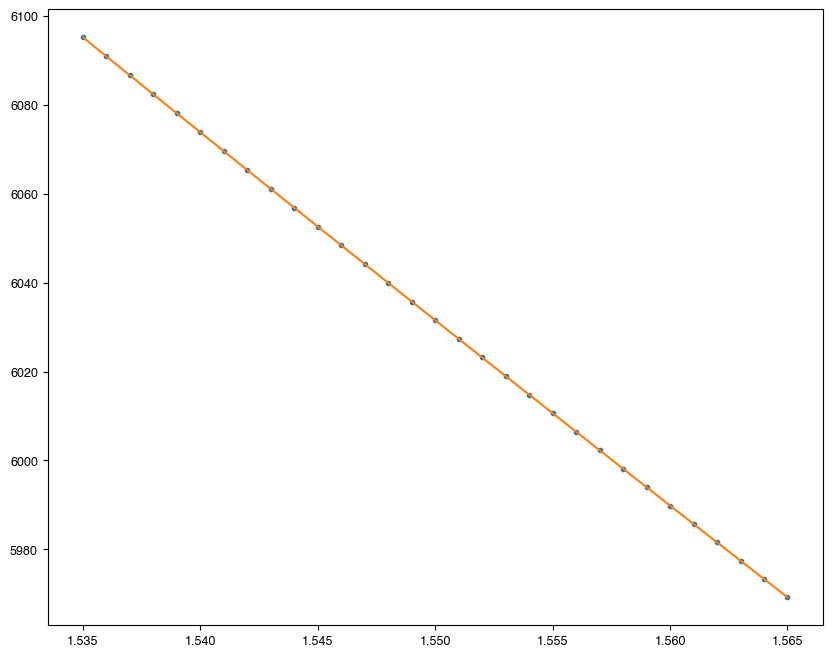

In [2479]:
plt.figure(figsize=(10,8))
plt.plot(lambda_arr_1, beta_uncoupled_arr_gap5um[:,3],marker='.',linestyle="")
plt.plot(lambda_arr_1_intp, beta_uncoupled_arr_intp_gap5um[:,2])

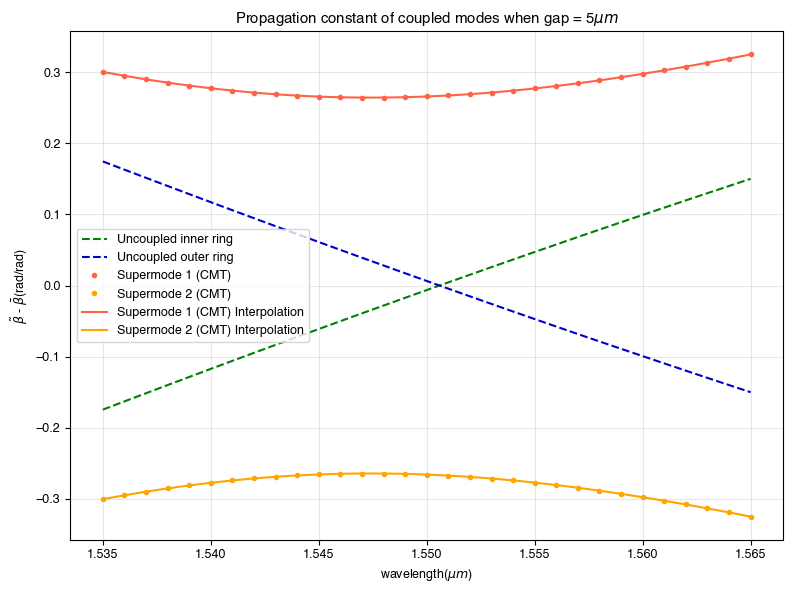

In [2480]:
beta_coupled_arr_intp_gap2_5um   = Interpolation(lambda_arr_1,
                                                beta_coupled_arr_gap2_5um[:,1:],
                                                lambda_arr_1_intp,num_of_pts)
coeffi_array, beta_uncoupled_arr_intp_gap2_5um = Polynomial_fit(lambda_arr_1,
                                                    beta_uncoupled_arr_gap2_5um[:,1:],
                                                    2, num_of_pts)
# beta_uncoupled_arr_intp_gap5um = Interpolation(lambda_arr_1,
#                                                beta_uncoupled_arr_gap5um[:,1:],num_of_pts)

data_arr        = (np.c_[lambda_arr_1,
                  beta_uncoupled_arr_gap2_5um[:,1:3],
                  beta_coupled_arr_gap2_5um[:,1:]],
                   np.c_[lambda_arr_1_intp,
                  beta_coupled_arr_intp_gap2_5um,],)

Plot_curve(data_arr,
           Y_legends=['Uncoupled inner ring','Uncoupled outer ring',
                      'Supermode 1 (CMT)','Supermode 2 (CMT)',
                      'Supermode 1 (CMT) Interpolation','Supermode 2 (CMT) Interpolation',
                      'Supermode 1 (FDE)','Supermode 2 (FDE)',
                      'Supermode 1 (FDE) Fit','Supermode 2 (FDE) Fit',
                      'Supermode 1 (FDE) Fit','Supermode 2 (FDE) Fit',
                      'Supermode 1 (FDE) Fit','Supermode 2 (FDE) Fit'],
            X_label=r'wavelength($\mu m$)',
            Y_label=r'$ \tilde{\beta}$ - $\bar{\beta}$(rad/rad)',
            title = r"Propagation constant of coupled modes when gap = 5$\mu m$",
            marker_list=["","",".",".","","","o","o","",""]*2,
            linestyle_list=["--","--","","","-","-","","","-","-"]*2,
            colors_list=['green','mediumblue','tomato','orange','tomato','orange',
                         'deepskyblue','lightskyblue','deepskyblue','lightskyblue']*2)


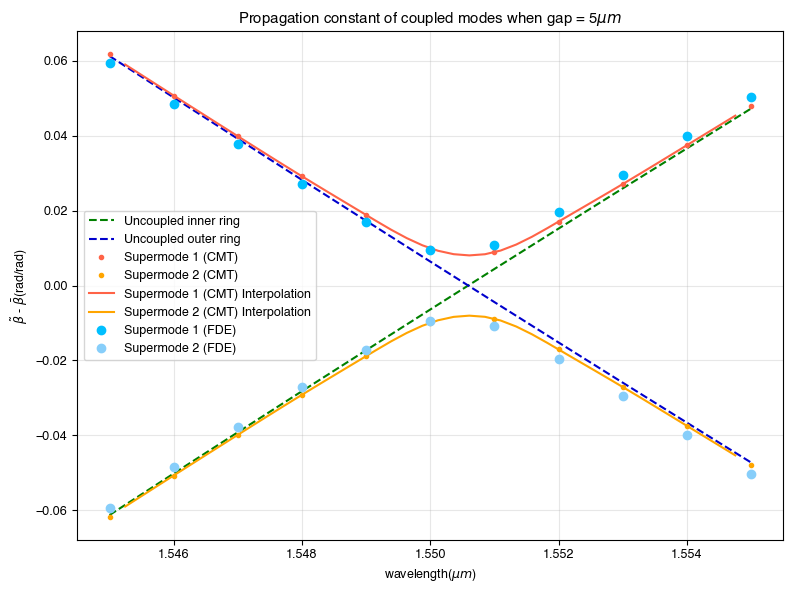

In [2481]:
data_arr        = (np.c_[lambda_arr_2,
                  beta_uncoupled_arr_gap5um[10:21,1:3],
                  beta_coupled_arr_gap5um[10:21,1:]],
                   np.c_[lambda_arr_2_intp,
                  beta_coupled_arr_intp_gap5um[lambda_arr_2_mask]],
                   np.c_[lambda_arr_2,
                  beta_coupled_lumerical_arr_gap5um[5:16,1:],],)

Plot_curve(data_arr,
           Y_legends=['Uncoupled inner ring','Uncoupled outer ring',
                      'Supermode 1 (CMT)','Supermode 2 (CMT)',
                      'Supermode 1 (CMT) Interpolation','Supermode 2 (CMT) Interpolation',
                      'Supermode 1 (FDE)','Supermode 2 (FDE)',
                      'Supermode 1 (FDE) Fit','Supermode 2 (FDE) Fit',
                      'Supermode 1 (FDE) Fit','Supermode 2 (FDE) Fit',
                      'Supermode 1 (FDE) Fit','Supermode 2 (FDE) Fit'],
            X_label=r'wavelength($\mu m$)',
            Y_label=r'$ \tilde{\beta}$ - $\bar{\beta}$(rad/rad)',
            title = r"Propagation constant of coupled modes when gap = 5$\mu m$",
            marker_list=["","",".",".","","","o","o","",""]*2,
            linestyle_list=["--","--","","","-","-","","","-","-"]*2,
            colors_list=['green','mediumblue','tomato','orange','tomato','orange',
                         'deepskyblue','lightskyblue','deepskyblue','lightskyblue']*2)


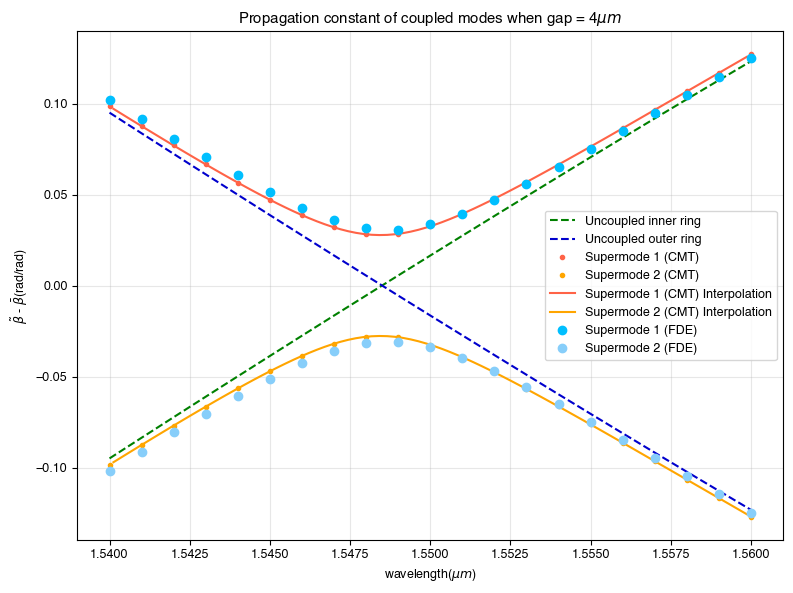

In [2482]:

beta_coupled_arr_intp_gap4um   = Interpolation(lambda_arr_1,
                                               beta_coupled_arr_gap4um[:,1:],
                                               lambda_arr_1_intp,num_of_pts)
coeffi_array, beta_uncoupled_arr_intp_gap4um = Polynomial_fit(lambda_arr_1,
                                                beta_uncoupled_arr_gap4um[:,1:],
                                                2, num_of_pts)
beta_coupled_lumerical_arr_gap4um_intp = np.c_[lambda_arr_3_intp,
                                               Interpolation(lambda_arr_3,
                                               beta_coupled_lumerical_arr_gap4um[:,1:],
                                               lambda_arr_3_intp,
                                               num_of_pts)]
np.shape(beta_coupled_arr_intp_gap4um)
Y_data          = (np.c_[lambda_arr_3,
                beta_uncoupled_arr_gap4um[5:26,1:3],
                beta_coupled_arr_gap4um[5:26,1:]],
                   np.c_[lambda_arr_3_intp,
                beta_coupled_arr_intp_gap4um[lambda_arr_3_mask]],
                   np.c_[lambda_arr_3,
                beta_coupled_lumerical_arr_gap4um[:,1:]],)

Plot_curve(Y_data,
           Y_legends=['Uncoupled inner ring','Uncoupled outer ring',
                      'Supermode 1 (CMT)','Supermode 2 (CMT)',
                      'Supermode 1 (CMT) Interpolation','Supermode 2 (CMT) Interpolation',
                      'Supermode 1 (FDE)','Supermode 2 (FDE)',
                      'Supermode 1 (FDE) Fit','Supermode 2 (FDE) Fit',],
            X_label=r'wavelength($\mu m$)',
            Y_label=r'$ \tilde{\beta}$ - $\bar{\beta}$(rad/rad)',
            title = r"Propagation constant of coupled modes when gap = 4$\mu m$",
            marker_list=["","",".",".","","","o","o","",""]*2,
            linestyle_list=["--","--","","","-","-","",""]*2,
            colors_list=['green','mediumblue','tomato','orange',
                         'tomato','orange','deepskyblue','lightskyblue',
                        'tomato','orange','deepskyblue','lightskyblue']*2)

In [2483]:
np.linspace(1.535,1.565,11)

array([1.535, 1.538, 1.541, 1.544, 1.547, 1.55 , 1.553, 1.556, 1.559,
       1.562, 1.565])

In [2484]:
# lambda_arr_1      = np.linspace(1.535,1.565,16)
# lambda_arr_1_intp = np.linspace(1.535,1.565,num_of_pts)

# data_arr        = (np.c_[lambda_arr_1,
#                   beta_uncoupled_arr_gap3um[:,1:3],
#                   beta_coupled_arr_gap3um[:,1:]],)


# Plot_curve(data_arr,
#            Y_legends=['Uncoupled inner ring','Uncoupled outer ring',
#                       'Supermode 1 (CMT)','Supermode 2 (CMT)',
#                       'Supermode 1 (CMT) Interpolation','Supermode 2 (CMT) Interpolation',
#                       'Supermode 1 (FDE)','Supermode 2 (FDE)',
#                       'Supermode 1 (FDE) Fit','Supermode 2 (FDE) Fit',
#                       'Supermode 1 (FDE) Fit','Supermode 2 (FDE) Fit',
#                       'Supermode 1 (FDE) Fit','Supermode 2 (FDE) Fit'],
#             X_label=r'wavelength($\mu m$)',
#             Y_label=r'$ \tilde{\beta}$ - $\bar{\beta}$(rad/rad)',
#             title = r"Propagation constant of coupled modes when gap = 5$\mu m$",
#             marker_list=["","",".",".","","","o","o","",""]*2,
#             linestyle_list=["--","--","","","-","-","","","-","-"]*2,
#             colors_list=['green','mediumblue','tomato','orange','tomato','orange',
#                          'deepskyblue','lightskyblue','deepskyblue','lightskyblue']*2)


In [2485]:
# beta_coupled_arr_intp_gap5um = Interpolation(lambda_arr_1,
#                                              beta_coupled_arr_gap5um[:,1:],
#                                              lambda_arr_1_intp,
#                                              num_of_pts)
# np.shape(beta_coupled_arr_intp_gap5um)


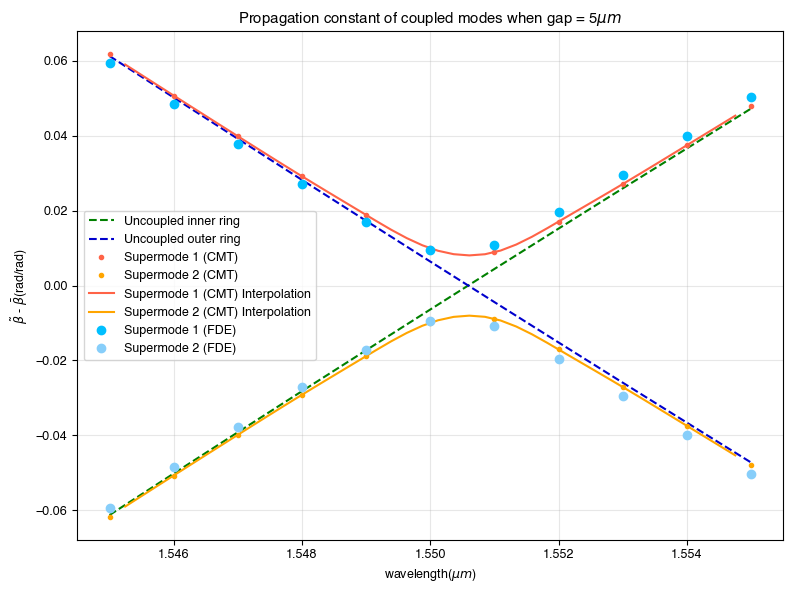

In [2486]:
# data_arr        = (np.c_[lambda_arr_2,
#                 beta_uncoupled_arr[10:21,1:3],
#                 beta_coupled_arr[10:21:,1:],],
#                    np.c_[lambda_arr_2,
#                 beta_coupled_lumerical_arr[5:16,1:]])
data_arr        = (np.c_[lambda_arr_2,
                beta_uncoupled_arr_gap5um[10:21,1:3],
                beta_coupled_arr_gap5um[10:21,1:]],
                   np.c_[
                lambda_arr_2_intp,
                beta_coupled_arr_intp_gap5um[lambda_arr_2_mask]],
                   np.c_[lambda_arr_2,
                beta_coupled_lumerical_arr_gap5um[5:16,1:]])

Plot_curve(data_arr,
           Y_legends=['Uncoupled inner ring','Uncoupled outer ring',
                      'Supermode 1 (CMT)','Supermode 2 (CMT)',
                      'Supermode 1 (CMT) Interpolation','Supermode 2 (CMT) Interpolation',
                      'Supermode 1 (FDE)','Supermode 2 (FDE)',
                      'Supermode 1 (FDE) Fit','Supermode 2 (FDE) Fit',],
            X_label=r'wavelength($\mu m$)',
            Y_label=r'$ \tilde{\beta}$ - $\bar{\beta}$(rad/rad)',
            title = r"Propagation constant of coupled modes when gap = 5$\mu m$",
            marker_list=["","",".",".","","","o","o","",""]*2,
            linestyle_list=["--","--","","","-","-","",""]*2,
            colors_list=['green','mediumblue','tomato','orange',
                         'tomato','orange','deepskyblue','lightskyblue',
                        'tomato','orange','deepskyblue','lightskyblue']*2)

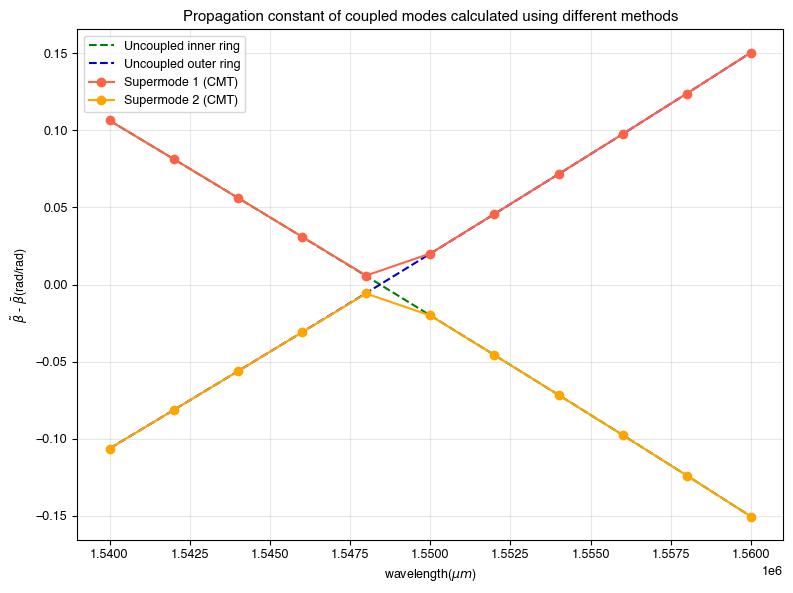

In [2487]:
lambda_arr = np.linspace(1.54,1.56,11)
Y_data = (np.c_[lambda_arr*1e6,
               beta_uncoupled_arr_L_inner_2_8[:,1:3],
               beta_coupled_arr_L_inner_2_8[:,1:]],)

Plot_curve(Y_data,
           Y_legends=['Uncoupled inner ring','Uncoupled outer ring',
                      'Supermode 1 (CMT)','Supermode 2 (CMT)',
                      'Supermode 1 (FDE)','Supermode 2 (FDE)',
                      'beta_iso_inner','beta_iso_outer'],
            X_label=r'wavelength($\mu m$)',
            Y_label=r'$ \tilde{\beta}$ - $\bar{\beta}$(rad/rad)',
            title = r"Propagation constant of coupled modes calculated using different methods",
            marker_list=["","","o","o","v","v"],
            linestyle_list=["--","--","-","-","-","-","-","-"])

Calculate the Dispersion curve

In [2488]:
def first_derivative_central_diff(y,x):
    # length of the arr will reduce by 2
    dy = np.diff(y)  # y[i+1] - y[i]
    dx = np.diff(x)  # x[i+1] - x[i]

    # Central Diff
    dy_central = (y[2:] - y[:-2])  # y[i+1] - y[i-1]
    dx_central = (x[2:] - x[:-2])  # x[i+1] - x[i-1]

    derivative = dy_central / dx_central

    return derivative

In [2489]:
def second_derivative_non_uniform(y, x):
    # 计算一阶差分
    dy_forward = (y[1:] - y[:-1]) / (x[1:] - x[:-1])  # 前向差分
    dy_backward = (y[1:] - y[:-1]) / (x[1:] - x[:-1])  # 后向差分

    # 计算二阶差分
    d2y = 2 * (dy_forward[1:] - dy_backward[:-1]) / (x[2:] - x[:-2])

    return d2y

In [2490]:
def Plot_Dispersion_curve(X,Y_arr,Y_legends,
                    X_label,Y_label,
                    title,marker_list,linestyle_list,
                    colors_list=['green','mediumblue','tomato','orange']*2,
                    bbox_to_anchor=(),
                    text = "",
                    dpi=400):
        #Plot parameters
        figsize = (8,6)
        fonttype = "Helvetica"
        fontsize = 10
        grid_linewidth = 0.8
        plot_linewidth = 1.5

        plt.figure(figsize=figsize)
        for idx in range(np.shape(Y_arr)[1]):
            plt.plot(X,Y_arr[:,idx],label=Y_legends[idx],
                        color=colors_list[idx], marker=marker_list[idx],
                        linestyle=linestyle_list[idx], linewidth=plot_linewidth)

        plt.rcParams["font.family"] = fonttype
        plt.rcParams.update({'font.size': fontsize})
        plt.yticks(fontproperties = fonttype, size = fontsize)
        plt.xticks(fontproperties = fonttype, size = fontsize)
        plt.ylabel(Y_label, fontdict={'family' : fonttype, 'size' : fontsize})
        plt.xlabel(X_label, fontdict={'family' : fonttype, 'size' : fontsize})
        plt.title(title)
        if len(bbox_to_anchor)>0:
            plt.legend(bbox_to_anchor=bbox_to_anchor, loc='upper left', borderaxespad=0)
        else:
            plt.legend(loc='upper left')
        if not text == "":
            plt.text(np.quantile(X,0.75),np.quantile(Y_arr,0.05),
                    text, bbox=dict(boxstyle="round,pad=0.9", fc="white", alpha=0.9))
        plt.grid(linewidth=grid_linewidth, alpha=0.3)
        savename = "results/"+str(title)+".jpg"
        plt.savefig(savename,dpi=dpi)
        plt.tight_layout()
        plt.show()

In [2491]:
def Anomalous_D_bandwidth(wavl_arr,beta_supermode):
        start_idx = int(len(beta_supermode)/2)
        start_idx = np.argmax(beta_supermode)
        left_zero = wavl_arr[start_idx]
        right_zero = wavl_arr[start_idx]
        left_found = False
        right_found = False
        for delta_idx in range(int(len(beta_supermode)/2)):
            if (not right_found) and (start_idx + delta_idx < len(beta_supermode)):
                idx = start_idx + delta_idx
                if beta_supermode[idx] > 0 and beta_supermode[idx+1] < 0:
                    right_zero =  wavl_arr[idx] + (wavl_arr[idx+1]-wavl_arr[idx])*\
                            beta_supermode[idx]/(beta_supermode[idx]-beta_supermode[idx+1])
                    right_found = True
                    print("Right Found, wavl:" + str(wavl_arr[idx]) + ", beta =" + str(beta_supermode[idx]))
                elif  beta_supermode[idx+1] > 0:
                    right_zero = wavl_arr[idx+1]

            if (not left_found) and (start_idx - delta_idx >= 0):
                idx = start_idx - delta_idx
                if beta_supermode[idx] > 0 and beta_supermode[idx-1] < 0:
                    left_zero =  wavl_arr[idx] + (wavl_arr[idx-1]-wavl_arr[idx])*\
                            beta_supermode[idx]/(beta_supermode[idx]-beta_supermode[idx-1])
                    left_found = True
                    print("Left Found, wavl:" + str(wavl_arr[idx]) + ", beta =" + str(beta_supermode[idx]))
                elif  beta_supermode[idx-1] > 0:
                    left_zero = wavl_arr[idx-1]
                # print("left wavl:" + str(wavl_arr[idx]) + ", beta =" + str(beta_supermode[idx]))
        return (right_zero-left_zero)*1e3   # nm

In [2492]:
c       = 3*10**8
um      = 10**-6

In [2493]:
gap         = 4*um
Lx_outer    = 2.436*um
R_WG1       = 1000*um
R_WG2       = R_WG1+gap+Lx_outer/2
R_ave       = (R_WG1+R_WG2)/2
R_ave

0.0010026090000000002

In [2494]:
def Calculate_dispersion_D(Beta,wavl_arr_):
    # Beta      : unit: rad/m
    # wavl_arr  : unit: um
    wavl_arr    = wavl_arr_ * 1e-6
    fre_arr     = 3*10**8 / (wavl_arr)
    Beta_1      = first_derivative_central_diff(Beta, fre_arr)
    Beta_1      = Beta_1 *10**(12) * 10**(3)        # unit: ps/km
    D           = first_derivative_central_diff(Beta_1, wavl_arr[1:-1])
    D           = D * 10**(-9)                          # unit: ps/km/nm
    return D, Beta_1


In [2495]:
beta_uncoupled_arr              = beta_uncoupled_arr_gap5um
beta_uncoupled_arr_intp         = beta_uncoupled_arr_intp_gap5um
beta_coupled_arr                = beta_coupled_arr_gap5um
beta_coupled_arr_intp           = beta_coupled_arr_intp_gap5um
beta_coupled_lumerical_arr      = beta_coupled_lumerical_arr_gap5um
beta_coupled_lumerical_arr_intp = beta_coupled_lumerical_arr_gap5um_intp
np.shape(beta_coupled_lumerical_arr_intp)

(82, 3)

In [2496]:
# beta_uncoupled_arr          = beta_uncoupled_arr_gap4um
# beta_uncoupled_arr_intp     = beta_uncoupled_arr_intp_gap4um
# beta_coupled_arr            = beta_coupled_arr_gap4um
# beta_coupled_arr_intp       = beta_coupled_arr_intp_gap4um
# beta_coupled_lumerical_arr  = beta_coupled_lumerical_arr_gap4um
# beta_coupled_lumerical_arr_intp = beta_coupled_lumerical_arr_gap4um_intp
# np.shape(beta_coupled_lumerical_arr_intp)

In [2497]:
beta_uncoupled_arr              = beta_uncoupled_arr_gap2_5um
beta_uncoupled_arr_intp         = beta_uncoupled_arr_intp_gap2_5um
beta_coupled_arr                = beta_coupled_arr_gap2_5um
beta_coupled_arr_intp           = beta_coupled_arr_intp_gap2_5um
# beta_coupled_lumerical_arr      = beta_coupled_lumerical_arr_gap2_5um
# beta_coupled_lumerical_arr_intp = beta_coupled_lumerical_arr_gap2_5um_intp

In [2498]:
beta_uncoupled_WG1_intp = (beta_uncoupled_arr_intp[:,0]+
                           beta_uncoupled_arr_intp[:,2])  / R_WG1     # unit: rad/m
beta_uncoupled_WG2_intp = (beta_uncoupled_arr_intp[:,1]+
                           beta_uncoupled_arr_intp[:,2])  / R_WG2     # unit: rad/m
beta_uncoupled_WG1 = (beta_uncoupled_arr[:,1]+beta_uncoupled_arr[:,3])  / R_WG1     # unit: rad/m
beta_uncoupled_WG2 = (beta_uncoupled_arr[:,2]+beta_uncoupled_arr[:,3])  / R_WG2     # unit: rad/m
np.shape(beta_uncoupled_WG1)
np.shape(lambda_arr_1_intp)

(124,)

Calculate Disperison of uncoupled waveguides

In [2499]:
D_WG1, Beta_1_WG1 = Calculate_dispersion_D(beta_uncoupled_WG1,lambda_arr_1)
D_WG1_intp, Beta_1_WG1_intp = Calculate_dispersion_D(beta_uncoupled_WG1_intp,lambda_arr_1_intp)
D_WG2, Beta_1_WG2 = Calculate_dispersion_D(beta_uncoupled_WG2,lambda_arr_1)
D_WG2_intp, Beta_1_WG2_intp= Calculate_dispersion_D(beta_uncoupled_WG2_intp,lambda_arr_1_intp)
np.shape(D_WG2_intp)

(120,)

Dispersion of supermodes calculated by CMT : lambda_1_arr: 1535-1565 nm

In [2500]:
np.shape(beta_coupled_arr_intp)

(124, 2)

In [2501]:
# beta_CMT_supermode1      = (beta_coupled_arr[:,1] +
#                               beta_uncoupled_arr[:,3])  / R_ave         # unit: rad/m
# beta_CMT_supermode2      = (beta_coupled_arr[:,2] +
#                               beta_uncoupled_arr[:,3])  / R_ave         # unit: rad/m
# beta_CMT_supermode1_intp = (beta_coupled_arr_intp[lambda_arr_3_mask][:,0] +
#                               beta_uncoupled_arr_intp[lambda_arr_3_mask][:,2])  / R_ave    # unit: rad/m
# beta_CMT_supermode2_intp = (beta_coupled_arr_intp[lambda_arr_3_mask][:,1] +
#                               beta_uncoupled_arr_intp[lambda_arr_3_mask][:,2])  / R_ave    # unit: rad/m

In [2515]:
beta_CMT_supermode1      = (beta_coupled_arr[:,1] +
                              beta_uncoupled_arr[:,3])  / R_ave         # unit: rad/m
beta_CMT_supermode2      = (beta_coupled_arr[:,2] +
                              beta_uncoupled_arr[:,3])  / R_ave         # unit: rad/m
beta_CMT_supermode1_intp = (beta_coupled_arr_intp[:,0] +
                              beta_uncoupled_arr_intp[:,2])  / R_ave    # unit: rad/m
beta_CMT_supermode2_intp = (beta_coupled_arr_intp[:,1] +
                              beta_uncoupled_arr_intp[:,2])  / R_ave    # unit: rad/m

In [2502]:
np.shape(beta_CMT_supermode1_intp)

(82,)

In [2516]:
D_supermode_1, Beta_1_supermode_1 = Calculate_dispersion_D(beta_CMT_supermode1,lambda_arr_1)
D_supermode_2, Beta_1_supermode_2 = Calculate_dispersion_D(beta_CMT_supermode2,lambda_arr_1)
D_supermode_1_intp, Beta_1_supermode_1_intp = Calculate_dispersion_D(beta_CMT_supermode1_intp,
                                                                    #  lambda_arr_3_intp)
                                                                    lambda_arr_1_intp)
D_supermode_2_intp, Beta_1_supermode_2_intp = Calculate_dispersion_D(beta_CMT_supermode2_intp,
                                                                    #  lambda_arr_3_intp)
                                                                    lambda_arr_1_intp)


Dispersion calculated by Lumerical FDE : lambda_3_arr 1540-1560 nm

In [2504]:
beta_coupled_lumerical_arr_ori  =\
np.c_[beta_coupled_lumerical_arr[:,0],
      beta_coupled_lumerical_arr[:,1]+beta_uncoupled_arr[5:26,3],
      beta_coupled_lumerical_arr[:,2]+beta_uncoupled_arr[5:26,3]]
beta_coupled_lumerical_arr_ori[:5,:]


array([[1.54000000e+00, 6.07392394e+03, 6.07369363e+03],
       [1.54100000e+00, 6.06965937e+03, 6.06945161e+03],
       [1.54200000e+00, 6.06540087e+03, 6.06521556e+03],
       [1.54300000e+00, 6.06114844e+03, 6.06098544e+03],
       [1.54400000e+00, 6.05690206e+03, 6.05676125e+03]])

In [2505]:
np.shape(beta_uncoupled_arr_intp)

(124, 3)

In [2506]:
beta_coupled_lumerical_arr_ori_intp  =\
np.c_[beta_coupled_lumerical_arr_intp[:,0],
      beta_coupled_lumerical_arr_intp[:,1]+beta_uncoupled_arr_intp[lambda_arr_3_mask][:,2],
      beta_coupled_lumerical_arr_intp[:,2]+beta_uncoupled_arr_intp[lambda_arr_3_mask][:,2]]
beta_coupled_lumerical_arr_ori_intp[:5,:]

array([[1.54012195e+00, 6.07340489e+03, 6.07317733e+03],
       [1.54036585e+00, 6.07236450e+03, 6.07214244e+03],
       [1.54060976e+00, 6.07132446e+03, 6.07110791e+03],
       [1.54085366e+00, 6.07028477e+03, 6.07007372e+03],
       [1.54109756e+00, 6.06924543e+03, 6.06903987e+03]])

In [2507]:
beta_coupled_lumerical_supermode1_ori  = beta_coupled_lumerical_arr_ori[:,1]  / R_ave
beta_coupled_lumerical_supermode2_ori  = beta_coupled_lumerical_arr_ori[:,2]  / R_ave
beta_coupled_lumerical_supermode1_ori_intp  = beta_coupled_lumerical_arr_ori_intp[:,1]  / R_ave
beta_coupled_lumerical_supermode2_ori_intp  = beta_coupled_lumerical_arr_ori_intp[:,2]  / R_ave

In [2508]:
D_lumerical_supermode_1, Beta_1_lumerical_supermode_1 = Calculate_dispersion_D(beta_coupled_lumerical_supermode1_ori, lambda_arr_3)
D_lumerical_supermode_2, Beta_1_lumerical_supermode_2 = Calculate_dispersion_D(beta_coupled_lumerical_supermode2_ori, lambda_arr_3)
D_lumerical_supermode_1

array([ -4311.48253858,  -4351.17184299,  -4426.47599266,  -4581.03711929,
        -4944.9075934 ,  -6034.51444055, -11002.40719615, -32569.54494575,
       -59679.39780067, -53627.69804049, -24308.94637097,  -8154.35291274,
        -4993.91940585,  -4195.28825253,  -1293.75103717,   1444.37381057,
        -1102.32659057])

In [2509]:
D_lumerical_supermode_1_intp, Beta_1_lumerical_supermode_1_intp = Calculate_dispersion_D(beta_coupled_lumerical_supermode1_ori_intp, lambda_arr_3_intp)
D_lumerical_supermode_2_intp, Beta_1_lumerical_supermode_2_intp = Calculate_dispersion_D(beta_coupled_lumerical_supermode2_ori_intp, lambda_arr_3_intp)
D_lumerical_supermode_1_intp[:5]

array([-2889.16946518, -3033.28047603, -3118.45203934, -3138.21690674,
       -3131.86873238])

Right Found, wavl:1.556, beta =1109.3058275003327
Left Found, wavl:1.5539999999999998, beta =1444.852395817682


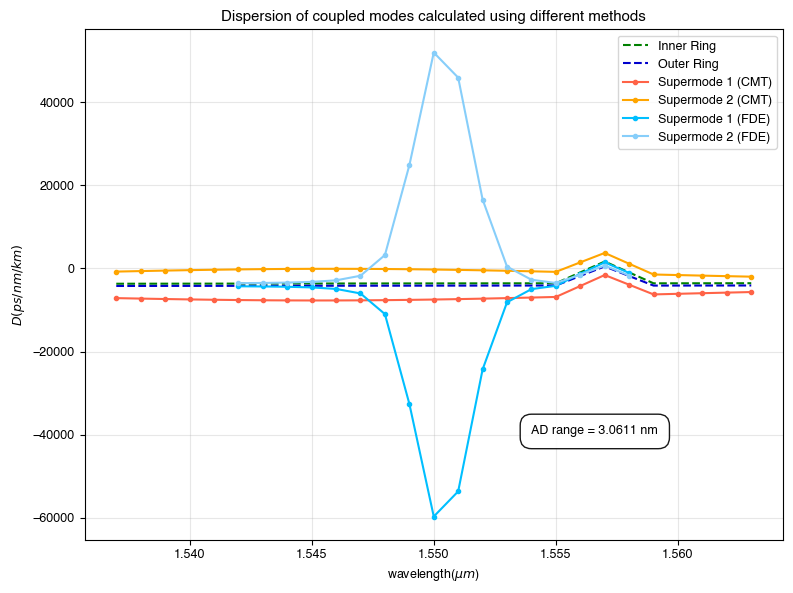

In [2510]:
AD_range_text = "AD range = "+"{:.4f}".format(Anomalous_D_bandwidth(
                 lambda_arr_1535_1565, D_supermode_2)) +" nm"
Y_data = (np.c_[ lambda_arr_1535_1565[2:-2],
                 D_WG1, D_WG2, D_supermode_1, D_supermode_2,],
          np.c_[ lambda_arr_1540_1560[2:-2],
                 D_lumerical_supermode_1,D_lumerical_supermode_2],)
Plot_curve(Y_data,
           Y_legends=['Inner Ring','Outer Ring',
                      'Supermode 1 (CMT)','Supermode 2 (CMT)',
                      'Supermode 1 (FDE)','Supermode 2 (FDE)'],
            X_label=r'wavelength($\mu m$)',Y_label=r'$D(ps/nm/km)$',
            title = "Dispersion of coupled modes calculated using different methods",
            marker_list=["","",".",".",".","."],
            linestyle_list=["--","--","-","-","-","-","-","-"],
            text=AD_range_text)

In [2511]:
AD_range_text = "AD range = "+"{:.4f}".format(Anomalous_D_bandwidth(
                 lambda_arr__intp[2:-2], D_supermode_2_intp)) +" nm"
Y_data = (np.c_[ lambda_arr_1_intp[2:-2],
                 D_WG1_intp, D_WG2_intp, D_supermode_1_intp, D_supermode_2_intp],)
       #    np.c_[ lambda_arr_3_intp[2:-2],
       #           D_lumerical_supermode_1_intp,D_lumerical_supermode_2_intp])
Plot_curve(Y_data,
           Y_legends=['Inner Ring','Outer Ring',
                      'Supermode 1 (CMT)','Supermode 2 (CMT)',
                      'Supermode 1 (FDE)','Supermode 2 (FDE)']*2,
            X_label=r'wavelength($\mu m$)',Y_label=r'$D(ps/nm/km)$',
            title = "Dispersion of coupled modes calculated using different methods",
            marker_list=["","","","","",""]*2,
            linestyle_list=["--","--","-","-","-","-","-","-"]*2,
            text=AD_range_text)

Left Found, wavl:1.5354878048780487, beta =927.831661635401


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 120 and the array at index 3 has size 78

In [ ]:
# AD_range_text = "AD range = "+"{:.4f}".format(Anomalous_D_bandwidth(
#                  lambda_arr_3_intp[2:-2], D_supermode_2_intp)) +" nm"
# Y_data = (np.c_[ lambda_arr_3_intp[2:-2],
#                  D_WG1_intp, D_WG2_intp, D_supermode_1_intp, D_supermode_2_intp],)
#        #    np.c_[ lambda_arr_3_intp[2:-2],
#        #           D_lumerical_supermode_1_intp,D_lumerical_supermode_2_intp])
# Plot_curve(Y_data,
#            Y_legends=['Inner Ring','Outer Ring',
#                       'Supermode 1 (CMT)','Supermode 2 (CMT)',
#                       'Supermode 1 (FDE)','Supermode 2 (FDE)']*2,
#             X_label=r'wavelength($\mu m$)',Y_label=r'$D(ps/nm/km)$',
#             title = "Dispersion of coupled modes calculated using different methods",
#             marker_list=["","","","","",""]*2,
#             linestyle_list=["--","--","-","-","-","-","-","-"]*2,
#             text=AD_range_text)

Left Found, wavl:1.540609756097561, beta =927.831661635401


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 78 and the array at index 1 has size 120

In [2330]:
Plot_curve(Y_data,
           Y_legends=['Inner Ring','Outer Ring',
                      'Supermode 1 (CMT)','Supermode 2 (CMT)',
                      'Supermode 1 (FDE)','Supermode 2 (FDE)']*2,
            X_label=r'wavelength($\mu m$)',Y_label=r'$D(ps/nm/km)$',
            title = "Dispersion of coupled modes calculated using different methods",
            marker_list=["","","","","",""]*2,
            linestyle_list=["--","--","-","-","-","-","-","-"]*2,
            text=AD_range_text)

NameError: name 'Y_data_gap4' is not defined